# Supervised learning/classification of Columbia River Basalt data

This script trains a logistic regression model for classifying CRB samples, focusing on major and trace lements (+/- magnetic polarity) at the formation and member levels

Authors: Rachel Hampton and Leif Karlstrom, 2024

In [92]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from sklearn.metrics.cluster import v_measure_score
from scipy import stats
#from sklearn.preprocessing import Normalizer
#from sklearn.preprocessing import PowerTransformer
from importlib import reload
import math
from sklearn.utils import resample
from IPython.display import display
import pickle
import sys
import importlib

sys.path.append('../../scripts/')
# Contains special functions used in the script
import GeochemFunctions as geofctns
importlib.reload(geofctns)

!pwd

/Users/leif/gitrepos/learngeochem/notebooks/Hampton_CRB


## Here is where we load data

In [93]:
############# CRB DATAFRAME UPDATED
#NOTE: the "Umtanum" member class has been dropped from this version
path = '/Users/leif/gitrepos/learngeochem/data/CRB/CRB_dataframe_completed_2024_V2.csv'
data_=pd.read_csv(path, header=0)

features_sorted = data_.sort_values(["MemberID"], ascending=True)

#############################################
######### Here is where we decide what elements/ features to classify on

#this one maximizes the number of samples
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3','Y','V', 'Nb', 'Ga', 'Cu','Zn', 'Pb', 'La', 'Ce', 'Th', 'U', 'Source'])

#this maximizes the accuracy by including more elements, still retaining Indian Ridge member from Reidel (restrictive...)
#features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'Cu', 'Zn', 'U', 'Source'])
features__ = features_sorted.drop(columns=['FeO*', 'FeO', 'Fe2O3', 'Ga', 'La', 'Ce', 'Zn','Pb','Th', 'U', 'Source'])

features_ = features__.dropna(axis=0, how='any')

#drop the "undifferentiated" member class --- come back to this later?
features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)

#############################################
######### Here is where we decide whether to classify on member vs formation 
#member level
# labels= features_.loc[:,'MemberID']
# label_names=features_.loc[:,'Member']

# IDlabel = 'MemberID'
# IDname = 'Member'

#formation level
labels= features_.loc[:,'FormationID']
## 0=PGB, 1=Steens, 2=Imnaha, 3=GRB, 4=Wanapum, 5=SMB

label_names=features_.loc[:,'Formation']
IDlabel = 'FormationID'
IDname = 'Formation'

df = features_
labels_df = labels#labelz #labelz is member level
#############################################
#Build lookup table connecting IDs to names of classes
# Find unique class IDs
unique_ID = labels.unique()

NumSamplesPerClass = []
ClassName = []

for value in unique_ID:
    corresponding_class = df[df[IDlabel] == value][IDname].values
    NumSamplesPerClass.append(len(corresponding_class))
    ClassName.append(df[df[IDlabel] == value][IDname].values[0])
    
LookupTable = pd.DataFrame({'MemberID': unique_ID, 'Member': ClassName, 'NumSamples': NumSamplesPerClass})
LookupTable = LookupTable.sort_values(by='MemberID')

print(LookupTable)
#save the features used 
filename = IDname+'LookupTable.pkl'
pickle.dump(LookupTable, open(filename, 'wb'))
print(df.columns)
#############################################

df = df.drop(columns=['Member', 'MemberID', 'FormationID', 'Formation', 'Polarity'])

print(df.head(3))

filename = 'TrainingDataFeatures.pkl' #_maximize_elements
pickle.dump(df.columns.values, open(filename, 'wb'))
#print(df.columns.values)

#make ratios between every feature and every other feature  
df = pd.DataFrame(geofctns.makeratios(df))

#power transform to normalize values
df = geofctns.normalizedata(df,'powert')

print(np.shape(df))


/var/folders/sc/l94184295fdfnlyrwdthmhwc0000gq/T/ipykernel_90874/735230004.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_.drop(features_.index[features_['MemberID'] == 47], inplace=True)


   MemberID           Member  NumSamples
3       0.0     PictureGorge         138
0       1.0           Steens         110
1       2.0           Imnaha         195
2       3.0      GrandeRonde        2286
4       4.0          Wanapum         960
5       5.0  SaddleMountains         911
Index(['SiO2', 'TiO2', 'Al2O3', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5',
       'Ni', 'Cr', 'Sc', 'V', 'Ba', 'Rb', 'Sr', 'Zr', 'Y', 'Nb', 'Cu',
       'Formation', 'Member', 'MemberID', 'FormationID', 'Polarity'],
      dtype='object')
         SiO2      TiO2      Al2O3       MnO       MgO        CaO      Na2O  \
0   48.960000  1.760000  15.330000  0.180000  7.390000  10.260000  2.820000   
89  48.863779  2.214191  18.050801  0.174041  4.820505  10.161439  3.452124   
88  48.223128  2.155195  16.888956  0.168799  6.751964   8.961256  3.264790   

         K2O      P2O5        Ni        Cr      Sc        V        Ba  \
0   0.460000  0.210000  179.0000  193.0000  27.520  292.000  372.0000   
89  0.72538

In [64]:
#################################
#if needed, divide up into stratigraphic labels of interest 

df_gr= features_.loc[(features_['FormationID'] == 3)]
df_st= data_.loc[(data_['FormationID'] == 1)]
df_sm= data_.loc[(data_['FormationID'] == 5)]
df_pg= data_.loc[(data_['FormationID'] == 0)]
df_im= data_.loc[(data_['FormationID'] == 2)]
df_wp= data_.loc[(data_['FormationID'] == 4)]
df_wap=data_.loc[(data_['MemberID'] == 20)]

df_mr=data_.loc[(data_['MemberID'] == 22)]


df_sb=data_.loc[(data_['MemberID'] == 30)]
#df_bs=data_.loc[(data_['MemberID'] == 9)]
#df_em=data_.loc[(data_['MemberID'] == 35)]
#df_tb=data_.loc[(data_['MemberID'] == 11)]
#df_rb=data.loc[(data['MemberID'] == 6)]
#df_pomona=data.loc[(data['MemberID'] == 39)]
#df_weippe=data.loc[(data['MemberID'] == 40)]
#df_mthr=data.loc[(data['MemberID'] == 17)]
df_gc=data_.loc[(data_['MemberID'] == 21)]
#df_fs=data_.loc[(data_['MemberID'] == 30)]
df_reversed_ = df_gr.loc[(data_['Polarity'] == 0)]

rv_labels= pd.DataFrame(df_reversed_.loc[:,'MemberID'])
df_reversed = df_reversed_.drop(columns=['Member','MemberID', 'FormationID', 'Polarity'])



df_gr= features_.loc[(features_['FormationID'] == 3)] #Grande Ronde
#df_gr.drop(df_gr.index[df_gr['MemberID'] == 48], inplace=True)
gr_labels= pd.DataFrame(df_gr.loc[:,'MemberID'])


#dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])
dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])

#Imnaha Data For Training
df_im= features_.loc[(features_['FormationID'] == 2)] #Grande Ronde
#df_gr.drop(df_gr.index[df_gr['MemberID'] == 48], inplace=True)
im_labels= pd.DataFrame(df_im.loc[:,'MemberID'])


#dfgr = df_gr.drop(columns=['Member','MemberID', 'FormationID'])
dfim = df_im.drop(columns=['Member','MemberID', 'FormationID'])



# Train model for formation level classification

In [94]:
############### Train model by iterating over the random state parameter

#no polarity for now
#df = df.drop(columns=['Polarity'])
    
t1 = time.time()
random_state=35
Accuracy=[]
for r in range(random_state):
    features_train, features_test, labels_train, labels_test = train_test_split(df, labels_df, test_size=.3, random_state=r, stratify = labels_df)
    lr1 = LogisticRegression(solver = 'lbfgs', max_iter=1000, multi_class='multinomial')
    lr1.fit(features_train, labels_train)

# We want to check model performance (accuracy)
    accuracy = lr1.score(features_test, labels_test)
    Accuracy.append(accuracy)    

35

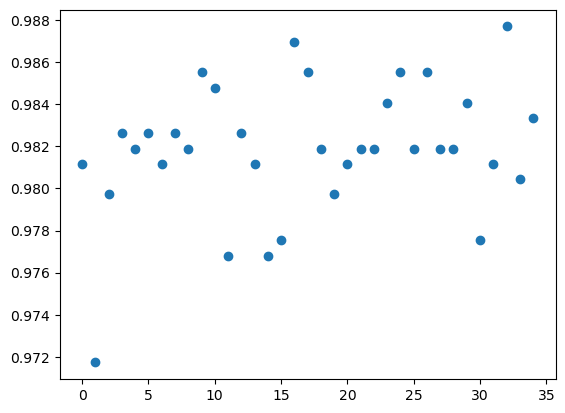

In [95]:
plt.figure()
plt.scatter(range(random_state), Accuracy)
random_state

In [96]:
accuracymax = max(Accuracy)
rspos = Accuracy.index(accuracymax)
xmax = range(random_state)[rspos]

run_time1 = time.time() - t1
print('Run Time 1=:', run_time1)

features_train_b, features_test_b, labels_train_b, labels_test_b = train_test_split(df, labels_df, test_size=0.3, random_state=xmax, stratify = labels_df)
lr_best = LogisticRegression(solver = 'lbfgs', max_iter=2500, multi_class='multinomial')
lr_best.fit(features_train_b, labels_train_b)

Run Time 1=: 41.538804054260254


LogisticRegression(max_iter=2500, multi_class='multinomial')

Precision: 0.9877605413759738
Recall: 0.9876811594202899


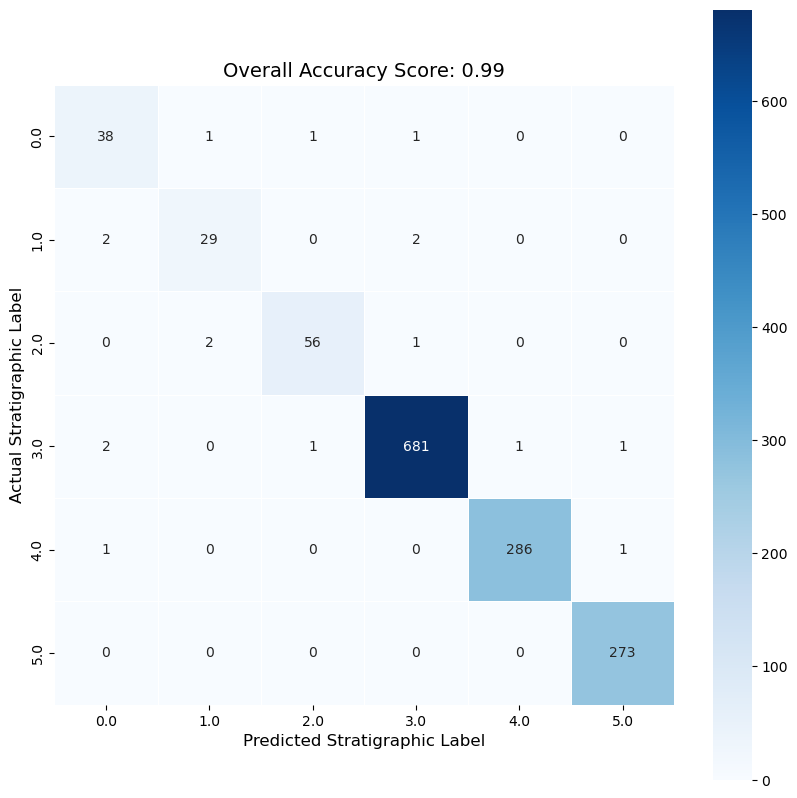

In [97]:
### Metrics for Test Data (accuracy, HCV, precision, recall)

predictions_best=lr_best.predict(features_test_b)

precision = metrics.precision_score(labels_test_b, predictions_best, average='weighted')
print('Precision:',precision)
recall = metrics.recall_score(labels_test_b, predictions_best, average='weighted')
print('Recall:',recall)
accuracy_best = lr_best.score(features_test_b, labels_test_b)

labels_test_b=pd.DataFrame(labels_test_b)

cm_labelz=labels_test_b.sort_values([IDlabel], ascending=True)
cm_labels=cm_labelz[IDlabel].unique()

### Plot Confusion Matrix
formations = ['Picture Gorge',' Steens', 'Imnaha', 'Grande Ronde', 'Wanapum', 'Saddle Mountains']
cm2 = pd.DataFrame(metrics.confusion_matrix(labels_test_b, predictions_best))
plt.figure(figsize=(10,10))
sns.heatmap(cm2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', xticklabels=cm_labels, yticklabels=cm_labels);
plt.ylabel('Actual Stratigraphic Label', fontsize=12);
plt.xlabel('Predicted Stratigraphic Label', fontsize=12);
all_sample_title = 'Overall Accuracy Score: {0}'.format("%.2f" % accuracy_best)
plt.title(all_sample_title, size = 14);

## Now generate a model that uses 100% of the data

After assessing accuracy on part of the training dataset, we want the best possible model to use for classifying unknown samples

In [98]:
#### With 100% of the data:
lr_best_100 = LogisticRegression(solver = 'lbfgs', max_iter=2500, multi_class='multinomial')
lr_best_100.fit(df, labels_df)

data_labels_100=labels_df

lr_best_100

LogisticRegression(max_iter=2500, multi_class='multinomial')

In [99]:
# save the model to disk, for fugure use
filename = 'CRB_' + IDname + '_trainedon_100pct_all_members.pkl' #_maximize_elements
pickle.dump(lr_best_100, open(filename, 'wb'))

datalabelname = 'CRB_' + IDname + '_labels_all_members.pkl' #_maximize_elements
pickle.dump(data_labels_100, open(datalabelname, 'wb'))